In [6]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
sys.path.append('../../..')
from src import bounded_mean_1d, load_image, rotated_embryo, raw_data_path
import scipy.stats as st
%matplotlib widget

if not os.path.exists('Figs'):
    os.mkdir('Figs')

### Import quantification

In [7]:
df = pd.read_csv("../../Run/Meiosis/df.csv")
res = pd.read_csv("../../Run/Meiosis/res.csv")

df_quant = pd.DataFrame()
for (id, frame), r in res.groupby(["EmbryoID", "Frame"]):
    cyt = np.mean(r["Cytoplasmic signal"])
    mem = np.mean(r["Membrane signal"])
    mem_post = bounded_mean_1d(r["Membrane signal"], [0.75, 0.25])
    total = cyt + (0.174 * mem)
    fraction_mem_post = (0.174 * 0.5 * mem_post) / total
    fraction_cyt = cyt / total
    p = {
        "EmbryoID": id,
        "Frame": frame,
        "Fraction_mem_post": fraction_mem_post,
        "Fraction_cyt": fraction_cyt,
    }
    df_quant = df_quant.append(pd.DataFrame(p, index=[id]), ignore_index=True)

### Fraction at posterior membrane

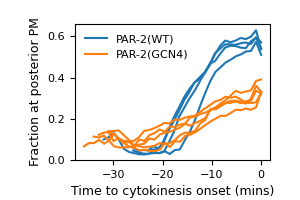

In [8]:
# Extract data
data_wt = []
data_gcn4 = []
for _, row in df.iterrows():
    data = df_quant[df_quant.EmbryoID == row.EmbryoID]["Fraction_mem_post"]
    if row.Line == "LP637":
        data_wt.append(data)
    else:
        data_gcn4.append(data)

# Figure
fig, ax = plt.subplots()
for d in data_wt:
    ax.plot(np.linspace(-len(d), 0, len(d)), d, c="tab:blue")
for d in data_gcn4:
    ax.plot(np.linspace(-len(d), 0, len(d)), d, c="tab:orange")

ax.plot([], [], c="tab:blue", label="PAR-2(WT)")
ax.plot([], [], c="tab:orange", label="PAR-2(GCN4)")
ax.legend(frameon=False, fontsize=8)

ax.set_ylim(bottom=0)
ax.set_xlabel("Time to cytokinesis onset (mins)", fontsize=9)
ax.set_ylabel("Fraction at posterior PM", fontsize=9)
ax.tick_params(axis="both", labelsize=8)
fig.set_size_inches(3, 2)
fig.subplots_adjust(bottom=0.2, left=0.25)
fig.savefig("Figs/posterior_pm_fraction.png", dpi=600, transparent=True)

### Fraction at cytoplasm

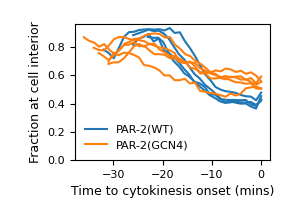

In [9]:
# Extract data
data_wt = []
data_gcn4 = []
for _, row in df.iterrows():
    data = df_quant[df_quant.EmbryoID == row.EmbryoID]["Fraction_cyt"]
    if row.Line == "LP637":
        data_wt.append(data)
    else:
        data_gcn4.append(data)

# Figure
fig, ax = plt.subplots()
for d in data_wt:
    ax.plot(np.linspace(-len(d), 0, len(d)), d, c="tab:blue")
for d in data_gcn4:
    ax.plot(np.linspace(-len(d), 0, len(d)), d, c="tab:orange")

ax.plot([], [], c="tab:blue", label="PAR-2(WT)")
ax.plot([], [], c="tab:orange", label="PAR-2(GCN4)")
ax.legend(frameon=False, fontsize=8)

ax.set_ylim(bottom=0)
ax.set_xlabel("Time to cytokinesis onset (mins)", fontsize=9)
ax.set_ylabel("Fraction at cell interior", fontsize=9)
ax.tick_params(axis="both", labelsize=8)
fig.set_size_inches(3, 2)
fig.subplots_adjust(bottom=0.2, left=0.25)
fig.savefig("Figs/cytoplasm_fraction.png", dpi=600, transparent=True)

### TImelapse images

5215.744660092949
5841.330374001647
7948.13784702759
11724.680687126602
4453.025185789136
4811.475099114732
5014.621951725357
5678.24445387931


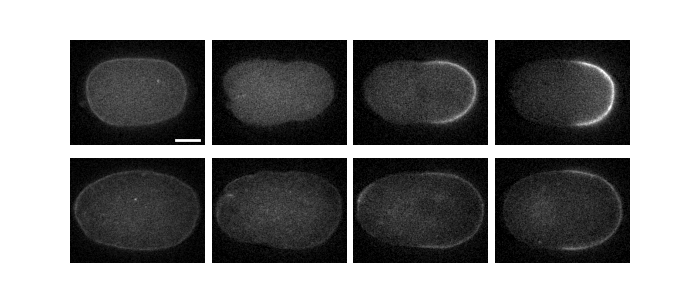

In [10]:
def figure_row(axs, path, scale_bar=False):
    cytokinesis = int(np.loadtxt(path + "/cytokinesis.txt"))
    img = load_image(glob.glob(path + "/*_corrected_*")[0])[:cytokinesis]
    rois = [
        np.loadtxt(path + "/Segmentation/ROI_fit_%s.txt" % (i + 1))
        for i in range(len(img))
    ]

    timepoints_mins = [-30, -20, -10, -1]
    timepoints = [t - 1 for t in timepoints_mins]
    for ax, t in zip(axs, timepoints):
        img_timepoint_rotated = rotated_embryo(img[t], rois[t], 230, 180, 3)
        print(np.percentile(img_timepoint_rotated, 99.9))
        ax.imshow(img_timepoint_rotated, cmap="gray", vmin=0, vmax=11724.680687126602)
        ax.axis("off")

    if scale_bar:
        px = 0.255  # pixel size
        bar_length = 10  # microns
        bar_pixels = bar_length / px
        y = img_timepoint_rotated.shape[0] - 10
        axs[0].plot(
            [
                img_timepoint_rotated.shape[1] - 10 - bar_pixels,
                img_timepoint_rotated.shape[1] - 10,
            ],
            [y, y],
            color="w",
            linewidth=2,
        )


if raw_data_path:
    fig, ax = plt.subplots(2, 4)
    figure_row(ax[0], df[df.Line == "LP637"].Path.iloc[0], scale_bar=True)
    figure_row(ax[1], df[df.Line == "NWG376"].Path.iloc[2])
    fig.set_size_inches(7, 3)
    fig.subplots_adjust(hspace=0.05, wspace=0.05, left=0.1, right=0.9)
    fig.savefig("Figs/timelapse.png", dpi=600, transparent=True)